Quick experiment to see which is better at detecting truthful answers

- model outputs
- hs
- supressed activations (Hypothesis this is better)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from loguru import logger
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
from einops import rearrange, repeat
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.data import DataCollatorForLanguageModeling

import torch
from torch import Tensor
from torch.nn.functional import (
    binary_cross_entropy_with_logits as bce_with_logits,
)
from torch.nn.functional import (
    cross_entropy,
)

from jaxtyping import Float
from torch import Tensor

from activation_store.collect import activation_store, default_postprocess_result

## Load model

In [4]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model_name = "unsloth/Llama-3.2-1B-Instruct"

# model_name = "Qwen/Qwen2.5-3B-Instruct"
# model_name = "Qwen/Qwen2.5-3B-Instruct-AWQ"

# model_name = "AMead10/Llama-3.2-3B-Instruct-AWQ"

# model_name = "unsloth/Phi-4-mini-instruct" # 4b
# model_name = "stelterlab/phi-4-AWQ"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16 if ('awq' not in model_name.lower()) else torch.float16,
    device_map="auto",
    attn_implementation="eager",  # flex_attention  flash_attention_2 sdpa eager
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.paddding_side = "left"
tokenizer.truncation_side = "left"

## Load data and tokenize

In [5]:
# N = 316
max_length = 256
split = "train"
ds1 = load_dataset("Yik/truthfulQA-bool", split=split, keep_in_memory=False)

sys_msg = """You will be given a statement, predict if it is true according to wikipedia, and return only 0 for false and 1 for true.
"""


def proc(row):
    messages = [
        {"role": "system", "content": sys_msg},
        {"role": "user", "content": row["question"]},
    ]
    return tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )


ds2 = ds1.map(proc).with_format("torch")
new_cols = list(set(ds2.column_names) - set(ds1.column_names)) + ["label"]
ds2 = ds2.select_columns(new_cols)
ds2

Map:   0%|          | 0/316 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 316
})

## Data loader

In [6]:
collate_fn = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
ds = DataLoader(ds2, batch_size=6, collate_fn=collate_fn)
print(ds)


## Collect activations

In [7]:
# choose layers to cache
layer_groups = {
    'mlp.down_proj': [k for k,v in model.named_modules() if k.endswith('mlp.down_proj')][10:25],
    'self_attn': [k for k,v in model.named_modules() if k.endswith('.self_attn')][10:25],
    'mlp.up_proj': [k for k,v in model.named_modules() if k.endswith('mlp.up_proj')][10:25],
}
# layer_groups = []

In [8]:
f = activation_store(ds, model, layers=layer_groups)
f

2025-03-15 08:40:22.002 | INFO     | activation_store.collect:activation_store:146 - creating dataset /media/wassname/SGIronWolf/projects5/elk/cache_transformer_acts/outputs/.ds/ds__622a0b062235193f.parquet


collecting activations:   0%|          | 0/53 [00:00<?, ?it/s]

PosixPath('/media/wassname/SGIronWolf/projects5/elk/cache_transformer_acts/outputs/.ds/ds__622a0b062235193f.parquet')

In [9]:
ds_a = Dataset.from_parquet(str(f), split=split).with_format("torch")
ds_a

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['acts-mlp.down_proj', 'acts-self_attn', 'acts-mlp.up_proj', 'loss', 'logits', 'hidden_states', 'label'],
    num_rows: 316
})

In [10]:
act_groups = [c for c in ds_a.column_names if c.startswith('acts-')]
act_groups

['acts-mlp.down_proj', 'acts-self_attn', 'acts-mlp.up_proj']

In [11]:
{k:v.shape for k,v in ds_a[0].items()}

{'acts-mlp.down_proj': torch.Size([6, 1, 2048]),
 'acts-self_attn': torch.Size([6, 1, 2048]),
 'acts-mlp.up_proj': torch.Size([6, 1, 8192]),
 'loss': torch.Size([]),
 'logits': torch.Size([1, 128256]),
 'hidden_states': torch.Size([17, 1, 2048]),
 'label': torch.Size([])}

In [12]:
# sanity test generate
b = next(iter(ds))
b = {k: v.to(model.device) for k, v in b.items()}
o = model.generate(
    inputs=b["input_ids"],
    attention_mask=b["attention_mask"],
    max_new_tokens=3,
)
gent = tokenizer.batch_decode(o, skip_special_tokens=False)
for g in gent:
    print(g)
    print("---")

<|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|>

## Get supressed activations

In [13]:
@torch.no_grad()
def get_supressed_activations(
    hs: Float[Tensor, "l b t h"], w_out, w_inv
) -> Float[Tensor, "l b t h"]:
    """
    Novel experiment: Here we define a transform to isolate supressed activations, where we hypothesis that style/concepts/scratchpads and other internal only representations must be stored.

    See the following references for more information:

    - https://arxiv.org/pdf/2401.12181
        - > Suppression neurons that are similar, except decrease the probability of a group of related tokens
        - > We find a striking pattern which is remarkably consistent across the different seeds: after about the halfway point in the model, prediction neurons become increasingly prevalent until the very end of the network where there is a sudden shift towards a much larger number of suppression neurons.

    - https://arxiv.org/html/2406.19384
        - > Previous work suggests that networks contain ensembles of “prediction" neurons, which act as probability promoters [66, 24, 32] and work in tandem with suppression neurons (Section 5.4).


    Output:
    - supression amount: This is a tensor of the same shape as the input hs, where the values are the amount of suppression that occured at that layer, and the sign indicates if it was supressed or promoted. How do we calulate this? We project the hs using the output_projection, look at the diff from the last layer, and then project it back using the inverse of the output projection. This gives us the amount of suppression that occured at that layer.
    """
    hs_flat = rearrange(hs[:, :, -1:], "l b t h -> (l b t) h")
    hs_out_flat = torch.nn.functional.linear(hs_flat, w_out)
    hs_out = rearrange(
        hs_out_flat, "(l b t) h -> l b t h", l=hs.shape[0], b=hs.shape[1], t=1
    )
    diffs = hs_out[:, :, :].diff(dim=0)
    diffs_flat = rearrange(diffs, "l b t h -> (l b t) h")
    # W_inv = get_cache_inv(w_out)

    diffs_inv_flat = torch.nn.functional.linear(diffs_flat.to(dtype=w_inv.dtype), w_inv)
    diffs_inv = rearrange(
        diffs_inv_flat, "(l b t) h -> l b t h", l=hs.shape[0] - 1, b=hs.shape[1], t=1
    ).to(w_out.dtype)

    # add on missing first layer
    torch.zeros_like(diffs_inv[:1]).to(hs.device)
    diffs_inv = torch.cat(
        [torch.zeros_like(diffs_inv[:1]).to(hs.device), diffs_inv], dim=0
    )
    return diffs_inv

In [14]:
def get_uniq_token_ids(tokens):
    token_ids = tokenizer(
        tokens, return_tensors="pt", add_special_tokens=False, padding=True
    ).input_ids
    token_ids = torch.tensor(list(set([x[0] for x in token_ids]))).long()
    print("before", tokens)
    print("after", tokenizer.batch_decode(token_ids))
    return token_ids


false_tokens = ["0", "0 ", "0\n", "false", "False "]
false_token_ids = get_uniq_token_ids(false_tokens)

true_tokens = ["1", "1 ", "1\n", "true", "True "]
true_token_ids = get_uniq_token_ids(true_tokens)

before ['0', '0 ', '0\n', 'false', 'False ']
after ['<|finetune_right_pad_id|>', '<|finetune_right_pad_id|>', '0', '0', 'False']
before ['1', '1 ', '1\n', 'true', 'True ']
after ['<|finetune_right_pad_id|>', '1', 'True', '1', '<|finetune_right_pad_id|>']


In [15]:
# now we map to 1) calc supressed activations 2) llm answer (prob of 0 vs prob of 1)

Wo = model.get_output_embeddings().weight.detach().clone().cpu()
Wo_inv = torch.pinverse(Wo.clone().float())


def proc(o):
    # TODO batch it
    """Process model outputs"""

    # get llm ans
    log_probs = o["logits"][-1].log_softmax(0)
    false_log_prob = log_probs.index_select(0, false_token_ids).sum()
    true_log_prob = log_probs.index_select(0, true_token_ids).sum()
    o["llm_ans"] = torch.stack([false_log_prob, true_log_prob])
    o["llm_log_prob_true"] = true_log_prob - false_log_prob

    # get supressed activations
    hs = o["hidden_states"][None]
    hs = rearrange(hs, "b l t h -> l b t h")
    diffs_inv = get_supressed_activations(hs, Wo.to(hs.dtype), Wo_inv.to(hs.dtype))

    # we will only take the last half of layers, and the last token
    layer_half = hs.shape[0] // 2
    
    hs = rearrange(hs, "l b t h -> b l t h").squeeze(0)[layer_half:-2]
    diffs_inv = rearrange(diffs_inv, "l b t h -> b l t h").squeeze(0)[layer_half:-2]

    o["hidden_states"] = hs.half()
    o["diffs_inv"] = diffs_inv.half()
    return o


ds_a2 = ds_a.map(proc, writer_batch_size=1, num_proc=None)
ds_a2

Map:   0%|          | 0/316 [00:00<?, ? examples/s]

Dataset({
    features: ['acts-mlp.down_proj', 'acts-self_attn', 'acts-mlp.up_proj', 'loss', 'logits', 'hidden_states', 'label', 'llm_ans', 'llm_log_prob_true', 'diffs_inv'],
    num_rows: 316
})

In [16]:
{k: v.shape for k,v in ds_a2[0].items() if isinstance(v, torch.Tensor)}


{'acts-mlp.down_proj': torch.Size([6, 1, 2048]),
 'acts-self_attn': torch.Size([6, 1, 2048]),
 'acts-mlp.up_proj': torch.Size([6, 1, 8192]),
 'loss': torch.Size([]),
 'logits': torch.Size([1, 128256]),
 'hidden_states': torch.Size([7, 1, 2048]),
 'label': torch.Size([]),
 'llm_ans': torch.Size([2]),
 'llm_log_prob_true': torch.Size([]),
 'diffs_inv': torch.Size([7, 1, 2048])}

## Predict

In [17]:
# # https://github.com/EleutherAI/ccs/blob/8a4bf687712cc03ef72973c8235944566d59053b/ccs/training/supervised.py#L9
# # TODO just replace with skotch or ridge regression

# class Classifier(torch.nn.Module):
#     """Linear classifier trained with supervised learning."""

#     def __init__(
#         self,
#         input_dim: int,
#         num_classes: int = 2,
#         device: str | torch.device | None = None,
#         dtype: torch.dtype | None = None,
#     ):
#         super().__init__()

#         self.linear = torch.nn.Linear(
#             input_dim, num_classes if num_classes > 2 else 1, device=device, dtype=dtype
#         )
#         self.linear.bias.data.zero_()
#         # self.linear.weight.data.zero_()

#     def forward(self, x: Tensor) -> Tensor:
#         return self.linear(x).squeeze(-1)

#     @torch.enable_grad()
#     def fit(
#         self,
#         x: Tensor,
#         y: Tensor,
#         *,
#         l2_penalty: float = 0.001,
#         max_iter: int = 10_000,
#     ) -> float:
#         """Fits the model to the input data using L-BFGS with L2 regularization.

#         Args:
#             x: Input tensor of shape (N, D), where N is the number of samples and D is
#                 the input dimension.
#             y: Target tensor of shape (N,) for binary classification or (N, C) for
#                 multiclass classification, where C is the number of classes.
#             l2_penalty: L2 regularization strength.
#             max_iter: Maximum number of iterations for the L-BFGS optimizer.

#         Returns:
#             Final value of the loss function after optimization.
#         """
#         optimizer = torch.optim.LBFGS(
#             self.parameters(),
#             line_search_fn="strong_wolfe",
#             max_iter=max_iter,
#         )

#         num_classes = self.linear.out_features
#         loss_fn = bce_with_logits if num_classes == 1 else cross_entropy
#         loss = torch.inf
#         y = y.to(
#             torch.get_default_dtype() if num_classes == 1 else torch.long,
#         )

#         def closure():
#             nonlocal loss
#             optimizer.zero_grad()

#             # Calculate the loss function
#             logits = self(x).squeeze(-1)
#             loss = loss_fn(logits, y)
#             if l2_penalty:
#                 reg_loss = loss + l2_penalty * self.linear.weight.square().sum()
#             else:
#                 reg_loss = loss

#             reg_loss.backward()
#             return float(reg_loss)

#         optimizer.step(closure)
#         return float(loss)


In [18]:
# # first try llm


# def roc_auc(y_true: Tensor, y_pred: Tensor) -> Tensor:
#     """Area under the receiver operating characteristic curve (ROC AUC).

#     Unlike scikit-learn's implementation, this function supports batched inputs of
#     shape `(N, n)` where `N` is the number of datasets and `n` is the number of samples
#     within each dataset. This is primarily useful for efficiently computing bootstrap
#     confidence intervals.

#     Args:
#         y_true: Ground truth tensor of shape `(N,)` or `(N, n)`.
#         y_pred: Predicted class tensor of shape `(N,)` or `(N, n)`.

#     Returns:
#         Tensor: If the inputs are 1D, a scalar containing the ROC AUC. If they're 2D,
#             a tensor of shape (N,) containing the ROC AUC for each dataset.
#     """
#     if y_true.shape != y_pred.shape:
#         raise ValueError(
#             f"y_true and y_pred should have the same shape; "
#             f"got {y_true.shape} and {y_pred.shape}"
#         )
#     if y_true.dim() not in (1, 2):
#         raise ValueError("y_true and y_pred should be 1D or 2D tensors")

#     # Sort y_pred in descending order and get indices
#     indices = y_pred.argsort(descending=True, dim=-1)

#     # Reorder y_true based on sorted y_pred indices
#     y_true_sorted = y_true.gather(-1, indices)

#     # Calculate number of positive and negative samples
#     num_positives = y_true.sum(dim=-1)
#     num_negatives = y_true.shape[-1] - num_positives

#     # Calculate cumulative sum of true positive counts (TPs)
#     tps = torch.cumsum(y_true_sorted, dim=-1)

#     # Calculate cumulative sum of false positive counts (FPs)
#     fps = torch.cumsum(1 - y_true_sorted, dim=-1)

#     # Calculate true positive rate (TPR) and false positive rate (FPR)
#     tpr = tps / num_positives.view(-1, 1)
#     fpr = fps / num_negatives.view(-1, 1)

#     # Calculate differences between consecutive FPR values (widths of trapezoids)
#     fpr_diffs = torch.cat(
#         [fpr[..., 1:] - fpr[..., :-1], torch.zeros_like(fpr[..., :1])], dim=-1
#     )

#     # Calculate area under the ROC curve for each dataset using trapezoidal rule
#     return torch.sum(tpr * fpr_diffs, dim=-1).squeeze()


In [34]:
TRAIN_TEST_SPLIT = int(max_length * 0.8)
TRAIN_TEST_SPLIT


204

In [35]:
# def train_linear_prob_on_dataset(
#     X,
#     name="",
#     device: str = "cuda",
# ):
#     X = X.view(len(X), -1).to(device)

#     # norm X
#     X = (X - X.mean()) / X.std()
#     y = ds_a2["label"].to(device)
#     X_train, y_train = X[:train_test_split], y[:train_test_split]
#     X_test, y_test = X[train_test_split:], y[train_test_split:]
#     # data.shape
#     lr_model = Classifier(X.shape[-1], device=device)
#     lr_model.fit(X_train, y_train)

#     y_pred = lr_model.forward(X_test)

#     score = roc_auc(y_test, y_pred)
#     logger.info(f"score for probe({name}): {score:.3f} roc auc, n={len(X_test)}. X.shape={X.shape}")
#     return score.cpu().item()

# Or Skorch

In [36]:
import numpy as np

from torch import nn

from skorch import NeuralNetRegressor
from skorch.toy import make_regressor

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
def train_linear_prob_on_dataset(
    X,
    name="",
    device: str = "cuda",
):
    X = X.view(len(X), -1).to(device)

    # norm X
    X = ((X - X.mean()) / X.std())
    if X.ndim == 1:
        X = X.unsqueeze(1)
    y = ds_a2["label"].to(device).float()
    if y.ndim == 1:
        y = y.unsqueeze(1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    # data.shape


    lr_model = NeuralNetRegressor(
        make_regressor(num_hidden=0, dropout=0, input_units=X.shape[-1]),
        lr=0.01,
        max_epochs=40,
        batch_size=128,
        device='cuda',  # uncomment this to train with CUDA
        optimizer=torch.optim.Adam,
        optimizer__weight_decay=0.001,
        verbose=0,
    )
    # lr_model = Classifier(X.shape[-1], device=device)
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.forward(X_test).detach().cpu().numpy()

    score = roc_auc_score(y_test.detach().cpu().numpy(), y_pred)
    logger.info(f"score for probe({name}): {score:.3f} roc auc, n={len(X_test)}. X.shape={X.shape}")
    return score#.cpu().item()

### score hidden states and activations

In [148]:
def calc_supp_thresh(hs, diffs_inv, eps = 1.0e-2):
    supressed_mask = (diffs_inv < -eps).to(hs.dtype)
    hs_sup = hs * supressed_mask
    return hs_sup, supressed_mask

In [149]:
reductions = {
    "mean": lambda x: x.mean(0),
    "max": lambda x: x.max(0)[0],
    "sum": lambda x: x.sum(0),
    "last": lambda x: x[-1],
    "first": lambda x: x[0],
    "none": lambda x: x,
}
results = []

ds_cols = [ "hidden_states",] + act_groups

# first try hidden states
for r1 in reductions:
    for ds_col in ds_cols:
        r1f = reductions[r1]
        try:
            X = torch.stack([r1f(x.float()) for x in ds_a2[ds_col]])
            name = f"{ds_col} {r1}"
            score = train_linear_prob_on_dataset(X, name)
            results.append((name, score))
        except Exception as e:
            logger.error(f"error with {name} {e}")
            raise e

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     5454.7261      583.6031  0.0037
      2     2078.6798     9424.0557  0.0029
      3     8158.7662     1208.8832  0.0030
      4      775.4660     2681.0491  0.0030
      5     3571.9695     3446.1045  0.0028
      6     2892.2342       12.6852  0.0028
      7      287.7320     2135.9163  0.0030
      8     2216.5433     1660.3341  0.0030
      9     1152.5307        9.3903  0.0031
     10      202.9288     1203.0222  0.0029
     11     1317.0392      676.8177  0.0029
     12      528.2184       60.5570  0.0030
     13      203.8739      789.4233  0.0030
     14      730.2530      271.1358  0.0030
     15      161.8891      101.9667  0.0029
     16      203.3969      433.6819  0.0030
     17      399.0026       48.1259  0.0029
     18       45.0875      157.5051  0.0030
     19      193.7960      212.1007  0.0030
     20      153.5864        1.5793  0.0029


2025-03-15 09:07:30.718 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(hidden_states mean): 0.672 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6990.8707     1145.7770  0.0034
      2     2358.3933    10958.3301  0.0030
      3    10247.7768     2418.7224  0.0030
      4     1501.8830     2163.8518  0.0029
      5     3428.4977     4828.6777  0.0029
      6     4359.0704      331.2622  0.0029
      7      372.5814     1718.5039  0.0030
      8     2123.3242     2629.2905  0.0029
      9     2085.1565      160.2065  0.0034
     10      125.5336      899.9916  0.0029
     11     1232.3763     1269.3701  0.0029
     12     1130.8090       33.6268  0.0029
     13       91.4897      636.0533  0.0030
     14      726.1590      696.3489  0.0030
     15      519.8677        3.2292  0.0030
     16       50.3361      408.3830  0.0030
     17      468.6112      285.1107  0.0029
     18      221.8944       15.6483  0.0029
     19       72.2668      286.0873  0.0030
     20      274.9131       84.3314  0.0030


2025-03-15 09:07:30.841 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-mlp.down_proj mean): 0.633 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6552.4677     1152.4845  0.0037
      2     2259.2015    10622.3428  0.0031
      3     9737.1340     2274.3210  0.0030
      4     1399.6544     2190.0896  0.0030
      5     3283.9221     4745.3926  0.0029
      6     4132.5775      319.6292  0.0030
      7      352.5164     1665.6119  0.0030
      8     2031.2867     2499.5007  0.0029
      9     1960.2056      133.2980  0.0029
     10      112.4836      920.4419  0.0030
     11     1183.4956     1256.8978  0.0031
     12     1070.0155       32.2973  0.0029
     13       88.8142      611.8925  0.0029
     14      694.1045      655.0726  0.0031
     15      485.0159        1.7478  0.0030
     16       48.4411      410.8939  0.0029
     17      449.5325      277.0955  0.0030
     18      209.3300       16.0965  0.0029
     19       71.4523      277.6570  0.0029
     20      259.6166       77.8719  0.0029


2025-03-15 09:07:30.967 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-self_attn mean): 0.548 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   107444.8270    10206.6494  0.0037
      2    41776.2780   181921.0312  0.0031
      3   159957.5106    13454.4658  0.0033
      4    12866.2184    69941.6797  0.0033
      5    79031.5882    64626.3398  0.0030
      6    47860.6431      474.4441  0.0032
      7     8735.3233    47460.0703  0.0030
      8    47915.7201    23543.7930  0.0030
      9    16007.5826     2974.3774  0.0031
     10     8373.4196    28894.1465  0.0036
     11    27270.1653     8536.5576  0.0038
     12     5873.5746     4331.8340  0.0030
     13     7787.8235    15899.1182  0.0033
     14    13695.3011     1714.6072  0.0030
     15     1196.9934     5527.8501  0.0030
     16     6950.8065     7885.2749  0.0030
     17     6067.3551       23.4867  0.0030
     18      768.6475     4929.9360  0.0033
     19     5139.3754     2227.3408  0.0038
     20     1516.2830      863.6072  0.0034


2025-03-15 09:07:31.152 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-mlp.up_proj mean): 0.583 roc auc, n=64. X.shape=torch.Size([316, 8192])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6502.9889     1111.8018  0.0038
      2     2239.3146    10351.5400  0.0030
      3     9562.7207     2237.6304  0.0032
      4     1365.0484     2107.7798  0.0032
      5     3246.9979     4572.4648  0.0032
      6     4063.3861      295.2373  0.0032
      7      349.9105     1654.7227  0.0031
      8     2013.1248     2444.2781  0.0032
      9     1911.3089      127.4903  0.0030
     10      108.4533      902.9250  0.0031
     11     1180.2303     1208.5847  0.0031
     12     1043.1266       27.8381  0.0030
     13       88.8522      608.9757  0.0033
     14      691.5747      629.0712  0.0032
     15      466.1635        1.9049  0.0039
     16       50.6968      410.4031  0.0033
     17      447.1107      265.8613  0.0040
     18      198.4002       18.7241  0.0036
     19       74.9820      268.9885  0.0035
     20      256.2256       69.2085  0.0039


2025-03-15 09:07:31.297 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(hidden_states max): 0.630 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     3478.4233      596.9764  0.0042
      2     1173.3872     5435.9609  0.0031
      3     5089.7265     1188.1105  0.0030
      4      746.4547     1109.9401  0.0031
      5     1703.8403     2455.8174  0.0031
      6     2165.4018      174.1160  0.0032
      7      185.1565      844.4711  0.0031
      8     1056.4996     1294.3628  0.0031
      9     1033.4652       74.0971  0.0030
     10       62.2090      463.7928  0.0032
     11      614.4338      645.3707  0.0031
     12      559.5244       17.4376  0.0030
     13       45.3459      314.3478  0.0031
     14      362.3497      341.1919  0.0032
     15      256.5222        0.9946  0.0032
     16       25.5792      209.4024  0.0030
     17      233.7434      143.8270  0.0031
     18      108.9991        7.7995  0.0031
     19       36.8240      142.0212  0.0032
     20      136.6991       40.4287  0.0031


2025-03-15 09:07:31.435 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-mlp.down_proj max): 0.623 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     3693.0689      590.5168  0.0039
      2     1356.7927     6213.1128  0.0032
      3     5443.1604     1228.7380  0.0032
      4      696.7095     1358.9937  0.0032
      5     1966.5795     2679.8567  0.0033
      6     2282.3362      139.3517  0.0029
      7      194.2524     1039.5616  0.0030
      8     1209.7116     1380.7703  0.0030
      9     1039.3526       46.0883  0.0033
     10       59.6366      604.9928  0.0035
     11      719.0974      704.0306  0.0031
     12      565.7226        9.4753  0.0033
     13       56.3860      384.8313  0.0035
     14      416.9188      340.9550  0.0033
     15      238.4408        3.2532  0.0032
     16       37.3134      263.8380  0.0033
     17      267.4226      140.1848  0.0032
     18      100.2666       20.5000  0.0035
     19       54.6490      163.7396  0.0034
     20      143.7352       31.0601  0.0031


2025-03-15 09:07:31.574 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-self_attn max): 0.719 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    93975.7513    16631.6348  0.0038
      2    31781.2191   151167.0312  0.0034
      3   138858.4985    33235.4453  0.0033
      4    20623.1538    30452.4316  0.0032
      5    46003.8071    68169.3047  0.0031
      6    59080.8874     4960.7266  0.0044
      7     5014.5785    23146.9414  0.0034
      8    28490.6412    36093.7344  0.0032
      9    28440.4194     2181.3613  0.0038
     10     1706.8838    12640.3672  0.0032
     11    16480.1771    18119.3750  0.0032
     12    15486.1141      563.3211  0.0031
     13     1258.4188     8504.8135  0.0031
     14     9691.8639     9630.7695  0.0033
     15     7124.7178       47.9583  0.0031
     16      630.9208     5656.1064  0.0032
     17     6299.9082     4088.2820  0.0030
     18     3119.4737      176.4862  0.0034
     19      931.2803     3935.3591  0.0034
     20     3696.3421     1225.3832  0.0030


2025-03-15 09:07:31.755 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-mlp.up_proj max): 0.600 roc auc, n=64. X.shape=torch.Size([316, 8192])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6115.0559     1013.7283  0.0038
      2     2113.1702     9864.7275  0.0030
      3     9038.9092     2077.0898  0.0030
      4     1275.3859     2047.2444  0.0030
      5     3101.0830     4335.6626  0.0031
      6     3798.6003      267.0773  0.0031
      7      311.5917     1588.9661  0.0031
      8     1925.7837     2295.3086  0.0030
      9     1798.8311      109.0304  0.0031
     10      104.9454      877.2702  0.0031
     11     1124.5189     1140.9253  0.0030
     12      968.8771       22.7065  0.0030
     13       81.5543      587.3163  0.0030
     14      661.7891      590.3050  0.0031
     15      435.4742        1.2808  0.0030
     16       50.8612      391.0385  0.0030
     17      424.4142      242.9659  0.0030
     18      181.7660       20.5566  0.0031
     19       73.3742      261.2618  0.0032
     20      241.8227       65.1348  0.0038


2025-03-15 09:07:31.889 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(hidden_states sum): 0.642 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6948.5696     1169.0370  0.0035
      2     2365.8340    10842.0605  0.0031
      3    10169.1653     2366.9260  0.0031
      4     1477.4312     2188.5535  0.0030
      5     3434.8420     4793.0732  0.0032
      6     4307.0507      312.5234  0.0030
      7      359.5323     1741.0745  0.0031
      8     2137.1995     2596.8840  0.0030
      9     2052.0014      145.3558  0.0032
     10      123.1038      919.1341  0.0031
     11     1246.1292     1244.8958  0.0030
     12     1104.7697       26.1784  0.0039
     13       90.9027      653.0763  0.0041
     14      735.0215      680.1773  0.0046
     15      500.9083        1.6841  0.0031
     16       54.0904      414.0794  0.0031
     17      472.9748      269.0810  0.0044
     18      210.1513       20.7775  0.0036
     19       78.1770      291.0936  0.0034
     20      273.2109       77.9248  0.0030


2025-03-15 09:07:32.020 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-mlp.down_proj sum): 0.626 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6416.6342     1013.0371  0.0034
      2     2175.9283    10518.9512  0.0031
      3     9572.7144     2016.2670  0.0030
      4     1264.6254     2365.0420  0.0031
      5     3414.5777     4533.7261  0.0030
      6     3895.4888      210.9623  0.0029
      7      307.3952     1830.6686  0.0028
      8     2133.2262     2370.0667  0.0030
      9     1803.7276       73.9529  0.0030
     10      104.8826     1016.2432  0.0030
     11     1259.6553     1146.4243  0.0030
     12      963.9891        7.6963  0.0030
     13       94.5098      687.1373  0.0030
     14      733.8926      581.8995  0.0029
     15      409.9236        3.9960  0.0029
     16       70.5787      445.3018  0.0030
     17      464.6322      222.9676  0.0029
     18      163.3379       38.2040  0.0030
     19       98.0266      280.9779  0.0030
     20      251.1311       47.8815  0.0030


2025-03-15 09:07:32.146 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-self_attn sum): 0.605 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   131157.4733    23246.0000  0.0034
      2    44147.6889   211278.0469  0.0030
      3   193639.6796    46503.8438  0.0030
      4    28939.4403    42545.5391  0.0030
      5    64046.7603    95396.9922  0.0029
      6    82200.1858     6968.2412  0.0031
      7     6877.3357    32333.0703  0.0030
      8    39738.2735    50504.4805  0.0032
      9    39753.3780     3073.4241  0.0029
     10     2428.1485    17605.9746  0.0029
     11    22945.1507    25243.6035  0.0030
     12    21536.3960      768.7469  0.0031
     13     1728.6600    11975.2676  0.0029
     14    13524.3780    13561.7031  0.0031
     15     9950.7909       73.1602  0.0030
     16      888.0592     7828.3887  0.0033
     17     8774.2113     5643.7002  0.0030
     18     4329.2494      262.6370  0.0030
     19     1295.7610     5571.3472  0.0030
     20     5162.4701     1747.8395  0.0031


2025-03-15 09:07:32.311 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-mlp.up_proj sum): 0.567 roc auc, n=64. X.shape=torch.Size([316, 8192])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6638.6498     1125.9937  0.0034
      2     2305.5358    10642.5078  0.0031
      3     9681.9596     2302.1394  0.0030
      4     1369.6960     2163.5481  0.0032
      5     3320.8210     4668.1206  0.0031
      6     4112.2027      291.1473  0.0031
      7      349.1878     1725.3463  0.0029
      8     2062.5182     2509.4336  0.0030
      9     1931.1034      126.2973  0.0031
     10      113.0369      933.0015  0.0030
     11     1210.8670     1218.8269  0.0030
     12     1042.0010       22.5829  0.0028
     13       88.6184      645.8519  0.0031
     14      712.4135      646.1367  0.0030
     15      465.1143        0.9789  0.0030
     16       55.4474      417.8399  0.0031
     17      457.3423      256.9025  0.0034
     18      193.0321       23.7080  0.0037
     19       80.4396      284.3640  0.0031
     20      260.4162       68.9549  0.0029


2025-03-15 09:07:32.441 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(hidden_states last): 0.638 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6201.1792     1042.6949  0.0035
      2     2090.5245     9554.3896  0.0030
      3     9117.9253     2079.3979  0.0030
      4     1349.4703     1951.5033  0.0033
      5     3049.1820     4302.0303  0.0031
      6     3851.0963      300.4564  0.0030
      7      314.4535     1489.5200  0.0030
      8     1898.8473     2270.4844  0.0029
      9     1859.1493      128.3210  0.0033
     10      115.6064      813.1782  0.0032
     11     1098.5070     1122.6454  0.0029
     12      993.1288       28.0014  0.0029
     13       77.7716      563.3810  0.0031
     14      651.7169      608.5820  0.0033
     15      460.6914        2.5136  0.0031
     16       47.0639      357.7685  0.0029
     17      418.0292      241.3608  0.0028
     18      192.7448       16.5268  0.0029
     19       65.9733      259.2054  0.0034
     20      244.7095       74.9133  0.0031


2025-03-15 09:07:32.570 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-mlp.down_proj last): 0.535 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     3623.2916      352.9774  0.0033
      2     1484.1185     6335.4062  0.0029
      3     5417.8186      584.0179  0.0030
      4      422.4323     2173.5786  0.0030
      5     2624.1018     2252.1782  0.0030
      6     1787.0110        5.8084  0.0030
      7      266.1045     1565.1249  0.0030
      8     1574.3301      922.5702  0.0029
      9      614.2321       52.6774  0.0029
     10      218.6383      945.9796  0.0041
     11      931.9212      369.9081  0.0044
     12      265.1197       92.4077  0.0043
     13      211.8819      534.5294  0.0043
     14      481.4452       95.5424  0.0041
     15       59.1960      145.9952  0.0041
     16      198.7453      301.3330  0.0043
     17      240.0153        9.9948  0.0042
     18       23.4820      137.8095  0.0050
     19      160.3286       98.3862  0.0035
     20       70.9577       14.8097  0.0032


2025-03-15 09:07:32.708 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-self_attn last): 0.456 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   110420.5917    19717.1445  0.0035
      2    36904.9754   176883.3125  0.0032
      3   162148.0906    39123.5117  0.0032
      4    24549.0980    35758.6172  0.0031
      5    53471.7723    80710.3594  0.0033
      6    68740.0302     6071.5786  0.0032
      7     5627.8789    26765.8145  0.0032
      8    33282.7499    42146.8438  0.0031
      9    33499.0575     2538.3408  0.0033
     10     2122.7766    14883.5859  0.0031
     11    19157.4127    21346.8164  0.0030
     12    17944.4552      665.3782  0.0031
     13     1396.9079    10010.1709  0.0033
     14    11361.7193    11373.3799  0.0031
     15     8376.9331       61.3357  0.0032
     16      760.2828     6560.9077  0.0031
     17     7343.5873     4707.6851  0.0030
     18     3605.0859      231.3902  0.0029
     19     1092.5904     4728.2827  0.0031
     20     4329.9126     1489.4829  0.0030


2025-03-15 09:07:32.874 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-mlp.up_proj last): 0.535 roc auc, n=64. X.shape=torch.Size([316, 8192])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6878.3117     1216.6544  0.0034
      2     2382.0688    11279.9561  0.0030
      3    10291.1759     2370.2104  0.0029
      4     1442.1448     2350.5115  0.0030
      5     3525.9851     4931.1401  0.0031
      6     4327.0067      292.6161  0.0031
      7      361.0791     1846.3556  0.0031
      8     2187.2032     2624.7986  0.0030
      9     2034.3551      118.1811  0.0032
     10      118.3201     1028.3672  0.0030
     11     1278.5231     1325.6880  0.0031
     12     1091.5813       28.2630  0.0031
     13       87.1756      658.7766  0.0031
     14      755.1784      654.4311  0.0038
     15      499.7236        2.0773  0.0033
     16       61.2210      462.8276  0.0030
     17      479.0618      282.6415  0.0030
     18      200.7178       23.8161  0.0032
     19       83.1189      300.4895  0.0033
     20      276.6252       74.8309  0.0031


2025-03-15 09:07:33.008 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(hidden_states first): 0.670 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       50.8675     9840.4746  0.0038
      2     5370.0008     5513.6094  0.0030
      3     6408.5136      720.3511  0.0030
      4     1101.3463     3813.5815  0.0029
      5     3421.6638     1629.7335  0.0031
      6      781.0032      860.1862  0.0032
      7     1543.5171     1660.3812  0.0033
      8     1475.4526       65.1283  0.0030
      9      343.9840     1493.8674  0.0030
     10     1244.6176      226.7441  0.0030
     11      136.0831      557.0643  0.0031
     12      699.1926      514.0840  0.0031
     13      376.4465       92.2199  0.0031
     14      214.0190      521.4379  0.0031
     15      421.5255       11.8478  0.0040
     16       49.3604      320.9825  0.0032
     17      312.6363       75.2182  0.0031
     18       54.3064      142.5596  0.0030
     19      170.2829      120.5506  0.0032
     20       79.3622       42.8445  0.0030


2025-03-15 09:07:33.135 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-mlp.down_proj first): 0.522 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     8064.5254     1379.3058  0.0034
      2     2867.8356    13382.1357  0.0030
      3    12381.7222     2663.8088  0.0030
      4     1681.1230     2893.2119  0.0030
      5     4306.6901     5791.6318  0.0030
      6     5149.3880      316.5961  0.0030
      7      417.0830     2209.1750  0.0033
      8     2664.9391     3038.0840  0.0036
      9     2418.7252      120.2867  0.0032
     10      138.9820     1235.9720  0.0030
     11     1555.9423     1533.8237  0.0030
     12     1299.8488       25.2543  0.0031
     13      105.8693      788.5076  0.0029
     14      912.3352      754.2896  0.0030
     15      588.5529        1.1432  0.0029
     16       74.1923      557.7812  0.0030
     17      577.5063      335.2583  0.0030
     18      235.1253       25.5248  0.0030
     19      101.0187      334.2884  0.0029
     20      334.3335       73.8462  0.0029


2025-03-15 09:07:33.261 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-self_attn first): 0.618 roc auc, n=64. X.shape=torch.Size([316, 2048])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   125177.3524    21893.0645  0.0037
      2    42883.4635   201322.0781  0.0030
      3   185811.6796    43809.7578  0.0031
      4    27030.8850    40680.4297  0.0030
      5    62134.4787    89672.7891  0.0032
      6    79095.9079     6194.6558  0.0035
      7     6820.0526    31393.6270  0.0030
      8    38404.4284    47899.3398  0.0038
      9    37669.9327     2769.8567  0.0043
     10     2184.5752    17014.9102  0.0047
     11    22323.3027    23899.7266  0.0036
     12    20619.2002      687.6772  0.0036
     13     1685.8276    11387.4463  0.0043
     14    13078.1774    12546.2275  0.0034
     15     9423.0352       45.4936  0.0033
     16      889.1661     7718.0039  0.0043
     17     8470.1494     5432.7515  0.0035
     18     4051.5649      251.7464  0.0032
     19     1277.8795     5168.4028  0.0031
     20     4983.4256     1528.8430  0.0045


2025-03-15 09:07:33.434 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-mlp.up_proj first): 0.603 roc auc, n=64. X.shape=torch.Size([316, 8192])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   288166.3769    46825.8633  0.0037
      2    99560.1411   469438.4375  0.0030
      3   427948.0020    98631.0625  0.0028
      4    59700.1933    96249.9609  0.0028
      5   147054.7620   203284.0469  0.0030
      6   180023.7307    12149.6523  0.0034
      7    15050.6784    76213.5000  0.0030
      8    90929.6826   109702.2031  0.0030
      9    84897.7234     5393.4604  0.0030
     10     4854.0829    40992.5156  0.0030
     11    53113.6392    53788.1250  0.0031
     12    46088.6605     1088.8606  0.0030
     13     3881.8036    27693.7148  0.0029
     14    31134.4505    28058.0547  0.0030
     15    20720.0921       58.4992  0.0031
     16     2346.8187    18494.8594  0.0031
     17    19993.4395    11733.1123  0.0030
     18     8705.4114      882.0654  0.0031
     19     3383.3607    12187.0723  0.0030
     20    11449.7800     3091.1680  0.0032


2025-03-15 09:07:33.567 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(hidden_states none): 0.634 roc auc, n=64. X.shape=torch.Size([316, 14336])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   167712.6624    28632.2383  0.0036
      2    57319.4925   265327.7812  0.0031
      3   246873.7759    58641.6016  0.0031
      4    36321.6999    52824.9297  0.0031
      5    82219.6384   118549.0469  0.0030
      6   105406.6889     8517.2168  0.0030
      7     9043.7054    40882.7305  0.0031
      8    50733.3676    63628.5469  0.0032
      9    50600.9275     3946.4392  0.0031
     10     3091.9199    21921.5156  0.0030
     11    29350.4829    31533.9023  0.0030
     12    27487.0719      974.5347  0.0030
     13     2201.0823    14970.8877  0.0030
     14    17285.9418    16944.2363  0.0030
     15    12726.9975       87.9622  0.0031
     16     1142.4773     9859.6064  0.0030
     17    11187.7741     7150.3813  0.0031
     18     5513.3859      311.0070  0.0031
     19     1652.4084     6882.3379  0.0030
     20     6603.4393     2147.1875  0.0032


2025-03-15 09:07:33.693 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-mlp.down_proj none): 0.575 roc auc, n=64. X.shape=torch.Size([316, 12288])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   200359.5911    35350.5312  0.0038
      2    68946.8146   325238.1562  0.0031
      3   298666.1891    70574.1406  0.0030
      4    43425.4644    65864.3359  0.0030
      5    99728.6874   145196.4688  0.0031
      6   127247.9083    10191.2734  0.0031
      7    10977.8694    50271.9023  0.0032
      8    61457.1154    77218.8438  0.0030
      9    60721.9816     4521.7896  0.0030
     10     3552.4248    27356.0059  0.0034
     11    35620.8284    38798.8281  0.0033
     12    33231.5287     1180.3079  0.0031
     13     2699.2649    18199.5977  0.0030
     14    20896.8858    20395.5410  0.0031
     15    15284.3315       81.9164  0.0030
     16     1376.5422    12291.2227  0.0030
     17    13557.4541     8822.9561  0.0029
     18     6678.3677      365.1744  0.0028
     19     2013.7535     8338.5361  0.0030
     20     7943.2596     2554.2834  0.0030


2025-03-15 09:07:33.818 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-self_attn none): 0.485 roc auc, n=64. X.shape=torch.Size([316, 12288])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  3861532.2158   681700.3125  0.0039
      2  1302048.0983  6226652.5000  0.0032
      3  5699243.0448  1383985.8750  0.0030
      4   853818.4549  1236009.2500  0.0035
      5  1876725.5995  2805121.2500  0.0031
      6  2431309.4534   209901.3750  0.0034
      7   208109.7011   944105.9375  0.0032
      8  1160142.6368  1496407.2500  0.0030
      9  1175265.2823    96461.2422  0.0031
     10    71881.2945   508257.5938  0.0033
     11   668968.0037   746758.6875  0.0032
     12   640679.2009    25185.9941  0.0031
     13    51678.0747   346212.9688  0.0030
     14   393452.6202   403386.6875  0.0032
     15   297312.4448     2892.1313  0.0030
     16    25108.2004   227039.7656  0.0033
     17   255894.8822   170130.4375  0.0032
     18   130606.9626     6427.0054  0.0034
     19    36272.0391   162226.3906  0.0034
     20   151839.2960    53730.2188  0.0036


2025-03-15 09:07:34.020 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(acts-mlp.up_proj none): 0.600 roc auc, n=64. X.shape=torch.Size([316, 49152])


### score supressed activations

In [150]:
def calc_hs_sup(o, eps = 1.0e-2):
    diffs_inv = o["diffs_inv"]
    hs = o["hidden_states"] # [b l h]
    if eps > 0:
        supressed_mask = (diffs_inv > eps).to(hs.dtype)# [b l h]
    else:
        supressed_mask = (diffs_inv < eps).to(hs.dtype)

    o['supressed_hs'] = hs * supressed_mask
    o['supressed_mask'] = supressed_mask
    # print({k:v.shape for k,v in o.items()})
    return o

In [151]:
{k: v.shape for k,v in ds_a2[0].items() if isinstance(v, torch.Tensor)}


{'acts-mlp.down_proj': torch.Size([6, 1, 2048]),
 'acts-self_attn': torch.Size([6, 1, 2048]),
 'acts-mlp.up_proj': torch.Size([6, 1, 8192]),
 'loss': torch.Size([]),
 'logits': torch.Size([1, 128256]),
 'hidden_states': torch.Size([7, 1, 2048]),
 'label': torch.Size([]),
 'llm_ans': torch.Size([2]),
 'llm_log_prob_true': torch.Size([]),
 'diffs_inv': torch.Size([7, 1, 2048])}

In [152]:
import gc
import numpy as np

In [153]:
X = ds_a2['logits']
name = "logits"
score = train_linear_prob_on_dataset(X, name)
results.append((name, score))
score

  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  29835234.2906  5564188.0000  0.0037
      2  10218620.4577  49394452.0000  0.0032
      3  44208861.0149  10935593.0000  0.0031
      4  6598222.5936  9830480.0000  0.0030
      5  14520903.0746  22259138.0000  0.0030
      6  18930724.2587  1681183.1250  0.0030
      7  1632625.6981  7525993.5000  0.0031
      8  8924445.5224  12047061.0000  0.0033
      9  9187630.4378   830402.7500  0.0030
     10   565599.2478  3961677.7500  0.0030
     11  5118301.3582  6018747.0000  0.0033
     12  5044880.8122   239294.7969  0.0037
     13   417681.4188  2650860.7500  0.0030
     14  2994502.0634  3232106.5000  0.0028
     15  2348284.1517    33126.7852  0.0028
     16   187163.0589  1762848.3750  0.0028
     17  1953785.8601  1405117.2500  0.0030
     18  1045190.0211    33083.9922  0.0028
     19   262974.3532  1230019.3750  0.0029
     20  1172439.1262   431830.1250  0.0030


2025-03-15 09:07:34.413 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(logits): 0.600 roc auc, n=64. X.shape=torch.Size([316, 128256])


np.float64(0.6000000000000001)

In [156]:

X = ds_a2['llm_ans']
y = ds_a2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

score = roc_auc_score(y_test, X_test[:, 0]).item()
results.append(('llm_ans', score))
score

0.5411764705882354

In [174]:
X = torch.sigmoid(ds_a2['llm_log_prob_true']/10)
y = ds_a2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

score = roc_auc_score(y_test, X_test).item()
results.append(('llm_log_prob_true', score))
score

0.6794117647058824

In [161]:

X, y = ds_a2["llm_log_prob_true"] > 0, ds_a2["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
score = roc_auc_score(X_test, y_test)
print(f"LLM score: {score:.2f} roc auc, n={len(X_test)}")

LLM score: 0.70 roc auc, n=64


In [162]:
# now various eps
for eps in [-10, -5, -1, -0.5, -0.1, -0.01, -0, 0, 0.01, 0.1, 0.5, 1, 10]:
    gc.collect()
    ds_a3 = ds_a2.map(lambda x:calc_hs_sup(x, eps=eps), num_proc=None, batched=True, batch_size=64, desc=f"eps {eps}")
    mask_mean = ds_a3['supressed_mask'].mean()
    print(f"eps {eps} ds_a3['supressed_mask'].mean()={mask_mean}")
    if mask_mean==0:
        logger.info(f"Skipping {eps} as no supressed activations")
        continue
    data_names = ["supressed_hs", "supressed_mask"]
    for ds_col in data_names:
        try:
            X = torch.stack([r1f(x) for x in ds_a3[ds_col]])
            name = f"{ds_col} {r1} {eps}"
            score = train_linear_prob_on_dataset(X, name)
            results.append((name, score))
        except Exception as e:
            print(f"error with {name}")
            print(e)


eps -50:   0%|          | 0/316 [00:00<?, ? examples/s]

eps -50 ds_a3['supressed_mask'].mean()=0.0
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1           nan           nan  0.0036
      2           nan           nan  0.0031
      3           nan           nan  0.0031
      4           nan           nan  0.0030
      5           nan           nan  0.0032
      6           nan           nan  0.0035
      7           nan           nan  0.0030
      8           nan           nan  0.0035
      9           nan           nan  0.0033
     10           nan           nan  0.0041
     11           nan           nan  0.0032
     12           nan           nan  0.0031
     13           nan           nan  0.0044
     14           nan           nan  0.0038
     15           nan           nan  0.0033
     16           nan           nan  0.0033
     17           nan           nan  0.0040
     18           nan           nan  0.0030
     19           nan           nan  0.0031
     20           nan           n

eps -10:   0%|          | 0/316 [00:00<?, ? examples/s]

eps -10 ds_a3['supressed_mask'].mean()=0.0
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1           nan           nan  0.0034
      2           nan           nan  0.0029
      3           nan           nan  0.0029
      4           nan           nan  0.0033
      5           nan           nan  0.0031
      6           nan           nan  0.0030
      7           nan           nan  0.0030
      8           nan           nan  0.0031
      9           nan           nan  0.0030
     10           nan           nan  0.0032
     11           nan           nan  0.0030
     12           nan           nan  0.0033
     13           nan           nan  0.0030
     14           nan           nan  0.0030
     15           nan           nan  0.0029
     16           nan           nan  0.0029
     17           nan           nan  0.0031
     18           nan           nan  0.0029
     19           nan           nan  0.0030
     20           nan           n

eps -5:   0%|          | 0/316 [00:00<?, ? examples/s]

eps -5 ds_a3['supressed_mask'].mean()=0.0
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1           nan           nan  0.0037
      2           nan           nan  0.0030
      3           nan           nan  0.0029
      4           nan           nan  0.0030
      5           nan           nan  0.0028
      6           nan           nan  0.0031
      7           nan           nan  0.0030
      8           nan           nan  0.0029
      9           nan           nan  0.0029
     10           nan           nan  0.0031
     11           nan           nan  0.0030
     12           nan           nan  0.0030
     13           nan           nan  0.0030
     14           nan           nan  0.0030
     15           nan           nan  0.0028
     16           nan           nan  0.0029
     17           nan           nan  0.0029
     18           nan           nan  0.0029
     19           nan           nan  0.0030
     20           nan           na

eps -1:   0%|          | 0/316 [00:00<?, ? examples/s]

eps -1 ds_a3['supressed_mask'].mean()=0.00013818447769153863
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      387.6666       66.4405  0.0034
      2      129.4807      601.0722  0.0040
      3      557.5235      114.6501  0.0032
      4       75.6313      143.9204  0.0030
      5      203.7526      265.6454  0.0029
      6      221.3828       10.7417  0.0030
      7       15.8464      109.7449  0.0030
      8      132.0942      128.0650  0.0031
      9      101.6077        1.7460  0.0030
     10        8.1548       67.2531  0.0030
     11       78.2968       62.0630  0.0032
     12       48.9324        0.2562  0.0030
     13        6.5693       44.7604  0.0029
     14       47.0358       28.9392  0.0041
     15       20.5046        1.5681  0.0034
     16        7.1752       27.7864  0.0046
     17       27.8376        8.9534  0.0039
     18        6.3595        5.1343  0.0040
     19        8.6165       16.8843  0.0035
     20       1

2025-03-15 09:10:01.587 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_hs none -1): 0.424 roc auc, n=64. X.shape=torch.Size([316, 14336])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      410.9514       71.5258  0.0036
      2      133.3653      639.7925  0.0030
      3      581.2070      138.7238  0.0033
      4       87.1578      136.8454  0.0031
      5      197.5285      297.2667  0.0030
      6      242.9306       20.8664  0.0031
      7       18.7873      100.4879  0.0030
      8      125.4000      147.9002  0.0031
      9      117.4075        6.5264  0.0034
     10        8.2067       60.0026  0.0030
     11       73.0610       75.4114  0.0030
     12       59.8737        1.3682  0.0030
     13        4.8513       40.2872  0.0029
     14       44.3834       38.5212  0.0028
     15       28.0014        0.2591  0.0029
     16        4.2311       26.5395  0.0030
     17       27.6950       15.1013  0.0030
     18       10.6200        2.0737  0.0030
     19        5.5759       17.9080  0.0031
     20       15.9071        3.9809  0.0030


2025-03-15 09:10:01.731 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_mask none -1): 0.500 roc auc, n=64. X.shape=torch.Size([316, 14336])


eps -0.5:   0%|          | 0/316 [00:00<?, ? examples/s]

eps -0.5 ds_a3['supressed_mask'].mean()=0.0005690727848559618
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     1193.6463      200.8291  0.0034
      2      415.4125     1785.9026  0.0030
      3     1762.4889      360.4077  0.0030
      4      249.6093      402.5534  0.0030
      5      611.3689      817.2548  0.0030
      6      727.9757       49.1403  0.0034
      7       54.2345      293.6786  0.0031
      8      385.9234      408.8076  0.0030
      9      349.9825       15.2753  0.0029
     10       23.1813      173.5668  0.0032
     11      224.3127      209.0171  0.0030
     12      180.6182        2.9118  0.0030
     13       15.4537      112.5819  0.0031
     14      133.8552      103.6676  0.0033
     15       81.4111        0.3824  0.0031
     16       12.0440       75.2607  0.0030
     17       84.4833       41.1053  0.0029
     18       32.0391        5.5987  0.0033
     19       16.4861       49.5618  0.0030
     20       

2025-03-15 09:10:03.292 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_hs none -0.5): 0.567 roc auc, n=64. X.shape=torch.Size([316, 14336])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     1556.9108      260.1816  0.0035
      2      743.8196     2156.3359  0.0031
      3     2212.9165      331.6062  0.0031
      4      247.7926      667.7407  0.0031
      5      933.1650     1011.9017  0.0029
      6      883.1744       45.3655  0.0029
      7       86.9522      459.9434  0.0031
      8      583.2836      444.5331  0.0030
      9      378.0879        1.9900  0.0030
     10       39.5357      298.6675  0.0037
     11      350.9588      234.9774  0.0035
     12      198.1627        3.8397  0.0036
     13       42.0319      171.2588  0.0030
     14      193.7665       91.6403  0.0032
     15       70.0850       12.4384  0.0031
     16       40.8527      109.8469  0.0030
     17      113.6529       27.5741  0.0031
     18       19.4890       25.2767  0.0031
     19       41.9093       59.2624  0.0031
     20       54.2637        2.0949  0.0041


2025-03-15 09:10:03.435 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_mask none -0.5): 0.561 roc auc, n=64. X.shape=torch.Size([316, 14336])


eps -0.1:   0%|          | 0/316 [00:00<?, ? examples/s]

eps -0.1 ds_a3['supressed_mask'].mean()=0.15346577763557434
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   108590.1969    18491.9863  0.0034
      2    38532.4809   173853.8906  0.0030
      3   161070.2484    37850.3594  0.0029
      4    22585.7186    34930.6328  0.0030
      5    54375.7170    77190.5547  0.0029
      6    69781.6534     5457.8701  0.0029
      7     6557.5176    26595.8438  0.0031
      8    33113.1163    40854.1523  0.0031
      9    32385.8379     2331.6382  0.0029
     10     1700.3444    14876.2256  0.0033
     11    19422.5272    21180.7930  0.0030
     12    18313.9906      740.3785  0.0030
     13     1629.5305     9314.1338  0.0031
     14    11224.0604    10556.4258  0.0029
     15     8152.0081       36.0115  0.0030
     16      689.5775     6763.2466  0.0029
     17     7398.5205     4922.0928  0.0029
     18     3740.9009      164.1920  0.0028
     19     1115.8947     4309.3667  0.0030
     20     4263

2025-03-15 09:10:04.967 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_hs none -0.1): 0.614 roc auc, n=64. X.shape=torch.Size([316, 14336])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   249556.4374    43118.7227  0.0034
      2    91455.0047   410657.8125  0.0030
      3   372507.3372    89507.4766  0.0028
      4    50506.8552    81795.8828  0.0030
      5   126667.3181   180794.2812  0.0031
      6   163832.6769    12987.0088  0.0047
      7    16418.9602    62032.3633  0.0040
      8    76146.9759    95406.8828  0.0032
      9    74485.0228     5447.2920  0.0031
     10     3609.1817    35507.8203  0.0030
     11    44977.9861    51007.8438  0.0034
     12    43269.5973     2092.7563  0.0032
     13     4091.7672    21162.2852  0.0032
     14    25672.8133    24682.5508  0.0036
     15    18909.5207      129.9437  0.0030
     16     1444.7255    15836.0400  0.0031
     17    17146.1498    11862.5518  0.0030
     18     9065.4693      322.8566  0.0029
     19     2523.5886    10004.2705  0.0041
     20     9800.1416     3231.8130  0.0031


2025-03-15 09:10:05.120 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_mask none -0.1): 0.563 roc auc, n=64. X.shape=torch.Size([316, 14336])


eps -0.01:   0%|          | 0/316 [00:00<?, ? examples/s]

eps -0.01 ds_a3['supressed_mask'].mean()=0.45614784955978394
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   164909.2521    18929.5566  0.0038
      2    67181.3117   284958.7500  0.0033
      3   249729.3420    33237.1953  0.0030
      4    21716.5613    87952.3047  0.0030
      5   113250.7583   106989.6719  0.0030
      6    89017.2480      370.4906  0.0032
      7     9823.1785    64935.0938  0.0034
      8    68719.7803    47736.8008  0.0031
      9    34001.2095      591.0782  0.0030
     10     6717.8580    39472.6367  0.0032
     11    40908.4052    21293.4668  0.0038
     12    15491.0824     1754.5791  0.0034
     13     6623.9115    23158.7891  0.0032
     14    22599.1064     7116.1255  0.0031
     15     4768.0590     3871.5056  0.0035
     16     6596.3200    14059.6377  0.0033
     17    12095.5596     1488.7211  0.0031
     18     1277.9353     4681.0322  0.0031
     19     6164.2169     5929.8799  0.0032
     20     457

2025-03-15 09:10:06.658 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_hs none -0.01): 0.394 roc auc, n=64. X.shape=torch.Size([316, 14336])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   415612.5904    70551.1953  0.0034
      2   145927.4793   681009.8125  0.0030
      3   621291.1224   140312.7031  0.0031
      4    81310.2290   143332.4688  0.0028
      5   216793.4140   295049.2812  0.0043
      6   266286.8930    17241.0039  0.0046
      7    25373.2014   111502.2969  0.0035
      8   131416.3773   157196.9219  0.0033
      9   119992.4008     6980.3335  0.0032
     10     5898.2890    63216.2656  0.0032
     11    78114.2390    82164.8906  0.0032
     12    68192.6615     2268.7729  0.0030
     13     6357.2601    37805.8555  0.0033
     14    44953.6294    38321.7148  0.0031
     15    29529.9961      133.7956  0.0034
     16     3149.0088    28762.2461  0.0035
     17    29361.5385    18441.4824  0.0032
     18    13311.6635      998.0493  0.0032
     19     5032.9265    16690.5645  0.0031
     20    16329.2418     4041.3767  0.0031


2025-03-15 09:10:06.811 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_mask none -0.01): 0.481 roc auc, n=64. X.shape=torch.Size([316, 14336])


eps 0:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 0 ds_a3['supressed_mask'].mean()=0.49798130989074707
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   187104.5318    28559.8828  0.0036
      2    67441.6813   308333.9062  0.0032
      3   281283.1720    54173.9570  0.0030
      4    33397.0487    74675.0938  0.0033
      5   106115.6119   130517.9297  0.0030
      6   113484.4005     4578.5698  0.0033
      7     9438.1452    56954.2930  0.0030
      8    65459.6959    66502.9375  0.0030
      9    50347.7376     1109.2972  0.0030
     10     3199.0167    32892.9453  0.0033
     11    39013.9108    32830.6953  0.0029
     12    26628.3277       63.6778  0.0031
     13     3089.9482    20786.9863  0.0037
     14    22637.7608    15093.1260  0.0060
     15    11003.2696      444.1273  0.0071
     16     2730.5604    14140.8857  0.0047
     17    13975.7570     5829.5073  0.0042
     18     4076.0163     1559.1569  0.0043
     19     3496.8545     8126.2969  0.0038
     20     7222.96

2025-03-15 09:10:08.416 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_hs none 0): 0.319 roc auc, n=64. X.shape=torch.Size([316, 14336])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   416785.0189    71404.4062  0.0037
      2   155124.7514   699243.8125  0.0032
      3   625825.8399   151429.6094  0.0030
      4    84338.5091   138300.2969  0.0031
      5   214441.2446   302341.1562  0.0032
      6   273541.5653    20629.0527  0.0030
      7    26227.5782   107106.3047  0.0030
      8   129213.6809   161238.7188  0.0029
      9   125485.2630     8906.7041  0.0031
     10     6550.8613    60786.1602  0.0031
     11    76027.4406    85443.2969  0.0030
     12    71494.8193     3286.3706  0.0029
     13     6502.9912    36384.8477  0.0029
     14    43700.7408    41083.1602  0.0031
     15    31555.6356      203.1705  0.0031
     16     2584.7557    27528.3867  0.0030
     17    28992.5237    20065.3164  0.0030
     18    14859.4189      582.6086  0.0030
     19     4366.5971    16575.9199  0.0032
     20    16515.5676     4970.1919  0.0030


2025-03-15 09:10:08.562 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_mask none 0): 0.606 roc auc, n=64. X.shape=torch.Size([316, 14336])


eps 0 ds_a3['supressed_mask'].mean()=0.49798130989074707
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   184976.7412    25261.6309  0.0041
      2    67852.1377   313393.6875  0.0032
      3   278581.9839    53782.5469  0.0033
      4    31776.5614    74552.6016  0.0036
      5   107522.2773   126181.3047  0.0036
      6   110964.1868     3510.6265  0.0031
      7     9260.1481    59181.1016  0.0032
      8    66325.9148    65203.9570  0.0032
      9    48435.1394      803.1065  0.0035
     10     3341.2767    33879.1484  0.0031
     11    39791.1892    31552.9961  0.0031
     12    25599.7955       68.0378  0.0033
     13     3475.4199    21415.5742  0.0033
     14    22832.5587    14164.2920  0.0034
     15    10032.5560      729.4471  0.0030
     16     3084.9819    14515.7920  0.0031
     17    14071.1015     5343.6021  0.0031
     18     3707.1557     1844.8248  0.0033
     19     3841.4153     7870.1294  0.0031
     20     6985.69

2025-03-15 09:10:09.021 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_hs none 0): 0.573 roc auc, n=64. X.shape=torch.Size([316, 14336])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   356594.1566    37881.3398  0.0049
      2   163050.3845   652624.9375  0.0032
      3   546569.0822    72679.9922  0.0031
      4    42977.8188   198629.2969  0.0032
      5   257871.5267   231030.7500  0.0030
      6   194977.0100      538.5727  0.0032
      7    23816.5690   149059.5312  0.0032
      8   153923.4747   102759.4531  0.0032
      9    71549.7154     2335.8713  0.0031
     10    16468.4599    90286.3438  0.0031
     11    92228.9712    45009.4805  0.0029
     12    33486.5285     5260.3984  0.0032
     13    16416.5231    52772.7852  0.0032
     14    49135.7136    14691.8633  0.0030
     15     8739.1636    10226.8623  0.0030
     16    15989.5000    31821.4844  0.0032
     17    27114.5956     3042.7126  0.0034
     18     3024.1491    10818.6387  0.0031
     19    14106.7913    12011.8799  0.0032
     20     9359.8161      432.3975  0.0030


2025-03-15 09:10:09.169 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_mask none 0): 0.479 roc auc, n=64. X.shape=torch.Size([316, 14336])


eps 0.01:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 0.01 ds_a3['supressed_mask'].mean()=0.459866464138031
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   217429.0917    36664.1992  0.0035
      2    76644.6936   350566.0625  0.0031
      3   323956.5222    72125.5625  0.0031
      4    43828.1321    74790.2734  0.0031
      5   112401.0942   154999.5938  0.0030
      6   137524.4663     9405.9062  0.0029
      7    12149.8754    56799.8359  0.0030
      8    68832.5663    81463.8828  0.0031
      9    63627.3189     3728.9563  0.0030
     10     3413.5231    31840.9121  0.0030
     11    40450.0469    41509.0742  0.0029
     12    35149.9861      942.4769  0.0029
     13     3048.9723    20257.1230  0.0030
     14    23532.9363    20540.7148  0.0031
     15    15602.5501       36.9168  0.0029
     16     1732.3441    14410.5781  0.0028
     17    15210.0007     9210.5977  0.0030
     18     6730.7157      579.4332  0.0030
     19     2593.3267     8908.8770  0.0030
     20     8616.0

2025-03-15 09:10:10.734 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_hs none 0.01): 0.438 roc auc, n=64. X.shape=torch.Size([316, 14336])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   405315.2276    62522.8945  0.0034
      2   144653.1528   681717.5625  0.0030
      3   607856.8495   130137.1406  0.0030
      4    73192.9591   149674.7969  0.0030
      5   223337.6940   280896.2812  0.0030
      6   254120.5475    11644.9268  0.0028
      7    23591.9268   121159.7656  0.0030
      8   135675.2013   151340.6562  0.0030
      9   111096.0308     4385.8750  0.0030
     10     5733.6908    67500.4688  0.0030
     11    81730.6610    75410.3594  0.0028
     12    62303.3926      847.3494  0.0028
     13     6686.8512    42094.5312  0.0028
     14    46796.1094    35085.9219  0.0030
     15    25560.9067      508.9964  0.0034
     16     4425.4420    29932.5898  0.0031
     17    30012.1425    14985.9688  0.0030
     18    10885.7799     2253.5486  0.0029
     19     6399.9664    17366.5625  0.0032
     20    15737.9998     2834.8665  0.0031


2025-03-15 09:10:10.873 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_mask none 0.01): 0.566 roc auc, n=64. X.shape=torch.Size([316, 14336])


eps 0.1:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 0.1 ds_a3['supressed_mask'].mean()=0.1529587358236313
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   131215.5079    22191.8594  0.0034
      2    44996.1302   206408.3281  0.0030
      3   194642.3875    42667.4609  0.0031
      4    26479.0228    44397.7031  0.0032
      5    66812.3471    92804.7812  0.0034
      6    82908.8009     5977.8882  0.0040
      7     7670.8529    33062.1445  0.0036
      8    40820.8302    48372.0586  0.0035
      9    38039.8434     2352.9890  0.0030
     10     1882.2927    18745.8516  0.0037
     11    24128.6274    25037.2051  0.0032
     12    21584.7450      693.5916  0.0034
     13     2008.4537    11662.5352  0.0034
     14    13878.7879    12202.8877  0.0032
     15     9352.4010       31.0041  0.0031
     16      931.8572     8581.5801  0.0033
     17     9121.3694     5740.4824  0.0032
     18     4257.4045      268.8126  0.0041
     19     1509.4775     5112.4146  0.0042
     20     5115.1

2025-03-15 09:10:12.469 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_hs none 0.1): 0.572 roc auc, n=64. X.shape=torch.Size([316, 14336])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   239336.0461    36834.4219  0.0037
      2    88097.9475   398766.2188  0.0035
      3   359346.1522    73515.5156  0.0039
      4    42476.1600    92084.0625  0.0033
      5   133536.8675   169274.8281  0.0033
      6   149635.6214     7229.7373  0.0040
      7    13673.3144    69721.2188  0.0033
      8    81146.5651    86385.7500  0.0030
      9    65268.5419     2025.0273  0.0032
     10     3358.5928    41346.2969  0.0031
     11    49075.1820    44931.9375  0.0030
     12    36917.3608      400.1285  0.0030
     13     4216.2797    24669.2656  0.0031
     14    27761.5151    20059.7480  0.0030
     15    14590.5525      354.3801  0.0031
     16     2708.9683    18131.7578  0.0031
     17    17996.6424     8891.4307  0.0031
     18     6347.1184     1285.6993  0.0030
     19     3901.1558     9891.2305  0.0030
     20     9285.9839     1427.9550  0.0037


2025-03-15 09:10:12.625 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_mask none 0.1): 0.482 roc auc, n=64. X.shape=torch.Size([316, 14336])


eps 0.5:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 0.5 ds_a3['supressed_mask'].mean()=0.00020153741934336722
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      319.5863       82.6414  0.0035
      2      430.9888      309.8003  0.0029
      3      378.4897       39.6592  0.0031
      4       56.8509      123.0489  0.0030
      5      281.9133      116.9829  0.0031
      6      187.0324       12.7209  0.0034
      7       48.8297      114.1787  0.0032
      8      136.4771       68.1401  0.0031
      9       65.4519       16.2239  0.0035
     10       43.1554       78.3064  0.0029
     11      103.1752       38.7615  0.0033
     12       39.1545        7.7295  0.0030
     13       16.6694       42.3593  0.0029
     14       49.2086       21.5382  0.0030
     15       25.7582        9.6071  0.0037
     16       20.7592       17.0939  0.0038
     17       19.1360        3.6534  0.0037
     18        5.3013       11.4391  0.0031
     19       16.6094       12.8353  0.0031
     20       

2025-03-15 09:10:14.217 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_hs none 0.5): 0.575 roc auc, n=64. X.shape=torch.Size([316, 14336])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      571.0894      124.1750  0.0034
      2      244.1914      865.6025  0.0040
      3      943.4402      183.1799  0.0031
      4      132.1135      209.2947  0.0030
      5      348.0315      395.1309  0.0032
      6      362.5689       29.6201  0.0030
      7       82.2276      126.1556  0.0030
      8      188.8448      158.1464  0.0029
      9      135.2281       11.2639  0.0031
     10       61.9260       63.0403  0.0031
     11      109.2839       53.3332  0.0058
     12       46.7269        3.4504  0.0037
     13       39.1373       41.1423  0.0031
     14       67.0731       18.5026  0.0030
     15       11.6967        4.3658  0.0039
     16       23.5674       20.7218  0.0031
     17       38.3280        2.1439  0.0030
     18        4.3826       12.9619  0.0031
     19       18.4343       14.0294  0.0037
     20       15.8805        1.7051  0.0034


2025-03-15 09:10:14.367 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_mask none 0.5): 0.610 roc auc, n=64. X.shape=torch.Size([316, 14336])


eps 1:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 1 ds_a3['supressed_mask'].mean()=4.6355812628462445e-06
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       45.6056        0.5469  0.0039
      2       29.8328        6.7266  0.0035
      3      183.7743        0.3887  0.0031
      4       11.4900        3.7568  0.0040
      5       78.3409        2.8390  0.0034
      6       62.7625        0.2746  0.0050
      7        2.7137        2.8485  0.0035
      8       41.0563        2.5133  0.0034
      9       34.2035        0.3126  0.0036
     10        1.6168        1.1434  0.0033
     11       19.8627        1.4878  0.0033
     12       20.1813        0.3628  0.0031
     13        1.2499        0.5404  0.0030
     14       10.1677        0.7951  0.0031
     15       11.6293        0.3061  0.0032
     16        0.8719        0.3643  0.0031
     17        5.8467        0.4137  0.0032
     18        6.2499        0.2496  0.0031
     19        0.4902        0.4267  0.0030
     20        3

2025-03-15 09:10:16.028 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_hs none 1): 0.483 roc auc, n=64. X.shape=torch.Size([316, 14336])


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       36.8616        3.2753  0.0037
      2       22.8219        3.9840  0.0032
      3      119.0938       21.8492  0.0030
      4       20.6512        5.5553  0.0030
      5       49.0268        3.0293  0.0032
      6       16.9371       19.5390  0.0035
      7       27.6815       14.6098  0.0042
      8       25.6531        1.9421  0.0033
      9        2.0166        1.8599  0.0034
     10       14.1596        6.2141  0.0032
     11        9.9812        4.8735  0.0032
     12        6.8744        1.7610  0.0034
     13       10.5147        0.3713  0.0029
     14        1.2688        0.3985  0.0036
     15        4.4758        1.3490  0.0039
     16        5.4011        2.1767  0.0035
     17        2.2210        1.2913  0.0032
     18        3.5055        0.2504  0.0033
     19        0.7179        1.0580  0.0031
     20        2.1232        1.5268  0.0030


2025-03-15 09:10:16.173 | INFO     | __main__:train_linear_prob_on_dataset:34 - score for probe(supressed_mask none 1): 0.483 roc auc, n=64. X.shape=torch.Size([316, 14336])


eps 10:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 10 ds_a3['supressed_mask'].mean()=0.0
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1           nan           nan  0.0040
      2           nan           nan  0.0043
      3           nan           nan  0.0035
      4           nan           nan  0.0034
      5           nan           nan  0.0035
      6           nan           nan  0.0035
      7           nan           nan  0.0036
      8           nan           nan  0.0034
      9           nan           nan  0.0037
     10           nan           nan  0.0035
     11           nan           nan  0.0038
     12           nan           nan  0.0035
     13           nan           nan  0.0034
     14           nan           nan  0.0034
     15           nan           nan  0.0035
     16           nan           nan  0.0034
     17           nan           nan  0.0034
     18           nan           nan  0.0035
     19           nan           nan  0.0035
     20           nan           na

eps 50:   0%|          | 0/316 [00:00<?, ? examples/s]

eps 50 ds_a3['supressed_mask'].mean()=0.0
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1           nan           nan  0.0036
      2           nan           nan  0.0033
      3           nan           nan  0.0032
      4           nan           nan  0.0031
      5           nan           nan  0.0030
      6           nan           nan  0.0034
      7           nan           nan  0.0035
      8           nan           nan  0.0035
      9           nan           nan  0.0031
     10           nan           nan  0.0035
     11           nan           nan  0.0031
     12           nan           nan  0.0032
     13           nan           nan  0.0037
     14           nan           nan  0.0035
     15           nan           nan  0.0031
     16           nan           nan  0.0033
     17           nan           nan  0.0029
     18           nan           nan  0.0030
     19           nan           nan  0.0031
     20           nan           na

In [176]:
import pandas as pd

# note hs_sup seems to get more important as we lower the thresh
df = pd.DataFrame(results, columns=["name", "auroc"]).sort_values(
    "auroc", ascending=False
)
df

,name,auroc
6,acts-self_attn max,0.718627
48,llm_log_prob_true,0.679412
47,llm_log_prob_true,0.679412
0,hidden_states mean,0.671569
16,hidden_states first,0.669608
8,hidden_states sum,0.642157
12,hidden_states last,0.638235
20,hidden_states none,0.634314
1,acts-mlp.down_proj mean,0.633333
4,hidden_states max,0.630392


In [177]:
df['data'] = df['name'].apply(lambda x: x.split()[0])
df2 = df.groupby('data').max().sort_values("auroc", ascending=False)
df2

,name,auroc
data,,
acts-self_attn,acts-self_attn sum,0.718627
llm_log_prob_true,llm_log_prob_true,0.679412
hidden_states,hidden_states sum,0.671569
acts-mlp.down_proj,acts-mlp.down_proj sum,0.633333
supressed_hs,supressed_hs none 1,0.613725
supressed_mask,supressed_mask none 1,0.610294
acts-mlp.up_proj,acts-mlp.up_proj sum,0.602941
logits,logits,0.600000
llm_ans,llm_ans,0.541176


PosixPath('../figs/truthfulqa_unsloth_Llama-3.2-1B-Instruct.png')

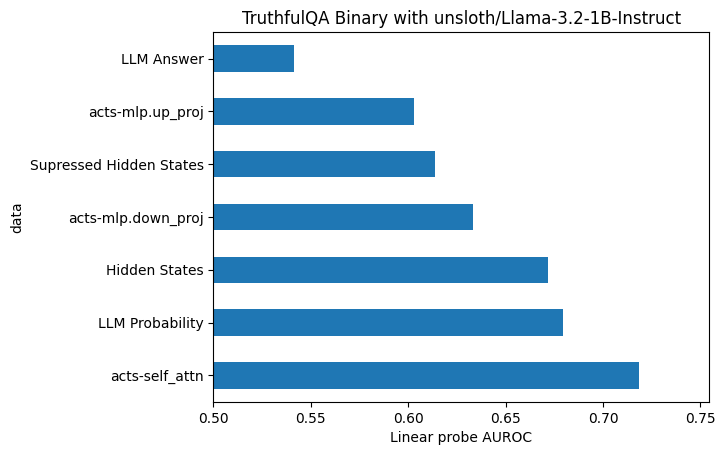

In [178]:
# plot it

from matplotlib import pyplot as plt
from pathlib import Path
from pathlib import Path

c = ['llm_ans', 'llm_log_prob_true', 'hidden_states',  'supressed_hs'] + act_groups
df3 = df2.T[c].rename(columns={
    'llm_ans': 'LLM Answer',
    'llm_log_prob_true': 'LLM Probability',
    'hidden_states': 'Hidden States',
    'acts': 'Activations: up_proj',
    # 'logits': 'Logits',
    'supressed_hs': 'Supressed Hidden States',
}).T.sort_values("auroc", ascending=False)
df3.plot.barh()
plt.legend().remove()
plt.xlabel(f"Linear probe AUROC")
plt.title(f"TruthfulQA Binary with {model_name}")
plt.xlim(0.5, None)
f = Path('../figs/').joinpath(f"truthfulqa_{model_name.replace('/', '_')}.png")
plt.savefig(str(f))
f